# Creating and Drawing Graphs 

These simple graphs are specifically for slides and to demonstrate concepts. 

In [1]:
%matplotlib inline 

import networkx as nx 
import graph_tool.all as gt 
import matplotlib.pyplot as plt 

from numpy.random import random
from datetime import datetime
from matplotlib import cm
from dateutil.parser import parse as dateparse

## Traversal 

In [ ]:
g, pos = gt.triangulation(random((1000, 2)) * 8, type="delaunay")
tree = gt.min_spanning_tree(g)
g.set_edge_filter(tree)

bv, be = gt.betweenness(g)
be.a /= be.a.max() / 5
bs = gt.prop_to_size(bv, mi=3, ma=10)

gt.graph_draw(g, pos=pos, vertex_fill_color=bv, vertex_size=bs, edge_pen_width=be, output="min_span_tree.png")

## Dynamic Graphs 

In [ ]:
g1 = gt.Graph() # Graph at timestep 1
g2 = gt.Graph() # Graph at timestep 2
g3 = gt.Graph() # Graph at timestep 3

# Add 5 vertices to g1 and g3 and 6 to g2 
g1.add_vertex(5)
g2.add_vertex(6)
g3.add_vertex(4)

# Create Property Maps 
for h in (g1, g2, g3):
    label = h.new_vertex_property('string')
    h.vp.label = label 
    
    for v,l in zip(h.vertices(), 'ABCDEF'):
        h.vp.label[v] = l 


# Add edges
g1e = (
    (0, 1), (0, 4), (0, 2), (3, 1), (3, 2), (4, 1)
)

for src, dst in g1e:
    g1.add_edge(g1.vertex(src), g1.vertex(dst))

g2e = (
    (0, 2), (1, 2), (2, 5), (3, 1), (3, 2), (4, 1)
)

for src, dst in g2e:
    g2.add_edge(g2.vertex(src), g2.vertex(dst))

g3e = (
    (0, 2), (0, 3), (3, 1), (3, 2), (2, 1)
)

for src, dst in g3e:
    g3.add_edge(g3.vertex(src), g3.vertex(dst))

In [ ]:
gt.graph_draw(g1, pos=gt.arf_layout(g1), vertex_text=g.vp.label, vertex_font_size=20, 
              vertex_fill_color="#9BDAF9", 
              vertex_pen_width=2, edge_pen_width=4)

In [ ]:
gt.graph_draw(g2, pos=gt.arf_layout(g2), vertex_text=g.vp.label, vertex_font_size=20, 
              vertex_fill_color="#9BDAF9", 
              vertex_pen_width=2, edge_pen_width=4)

In [ ]:
gt.graph_draw(g3, pos=gt.arf_layout(g3), vertex_text=g.vp.label, vertex_font_size=20, 
              vertex_fill_color="#9BDAF9", 
              vertex_pen_width=2, edge_pen_width=4)

# Filtering 

In [ ]:
g = gt.load_graph("data/email_multigraph.gt")

In [21]:
def sent_range(g, before=None, after=None):
    """
    Returns an edge filter for edges between the before and after. 
    """
    
    def inner(edge):
        if before and after:
            return g.ep.sent[edge] < before and g.ep.sent[edge] > after
        if before:
            return g.ep.sent[edge] < before 
        if after:
            return g.ep.sent[edge] > after 
    
    return inner 

def degree_filter(degree=0):
    """
    Returns a vertex filter for vertices that have the minimum degree.
    """
    
    def inner(vertex):
        return vertex.out_degree() > degree

    return inner

In [4]:
print("{} vertices and {} edges".format(g.num_vertices(), g.num_edges()))

6174 vertices and 343702 edges


In [34]:
view = gt.GraphView(g, efilt=sent_range(g, after=dateparse("Aug 1, 2016 09:00:00 EST"), before=dateparse("Aug 31, 2016 17:00:00 EST")))
view = gt.GraphView(view, vfilt=degree_filter())
print("{} vertices and {} edges".format(view.num_vertices(), view.num_edges()))

736 vertices and 22179 edges


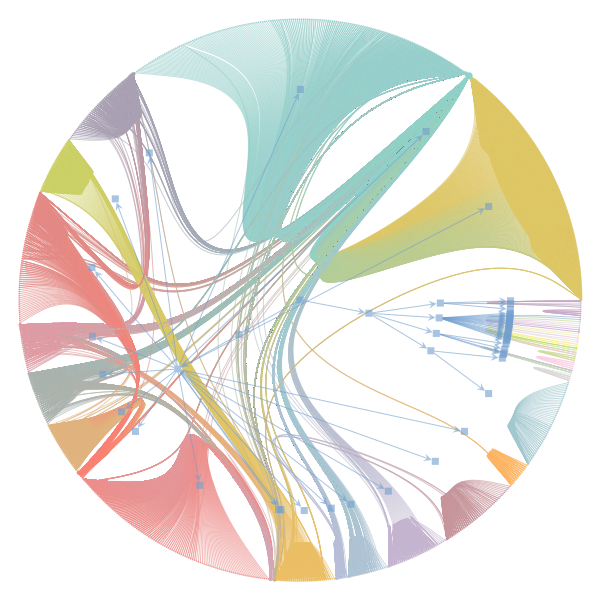

(<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x1050c7d90, at 0x119173a90>,
 <Graph object, directed, with 907 vertices and 906 edges, edges filtered by (<PropertyMap object with key type 'Edge' and value type 'bool', for Graph 0x1050c7a90, at 0x1050ced50>, False), vertices filtered by (<PropertyMap object with key type 'Vertex' and value type 'bool', for Graph 0x1050c7a90, at 0x1050c7710>, False) at 0x1050c7a90>,
 <PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x1050c7a90, at 0x1050c7750>)

In [33]:
state = gt.minimize_nested_blockmodel_dl(view, deg_corr=True)
gt.draw_hierarchy(state)

## Centrality 

In [5]:
f = gt.Graph(directed=False)
f.gp.name = f.new_graph_property('string')
f.gp.name = 'Betweeness Graph'

f.vp.label = f.new_vertex_property('string')

for c in 'ABCDEFG':
    v = f.add_vertex()
    f.vp.label[v] = c 

edges = [
    (0,1), (0,2), 
    (1,2), (1,4), 
    (2,3), (2,4), 
    (4,5), (4,6),
]

for src, dst in edges:
    f.add_edge(f.vertex(src), f.vertex(dst))

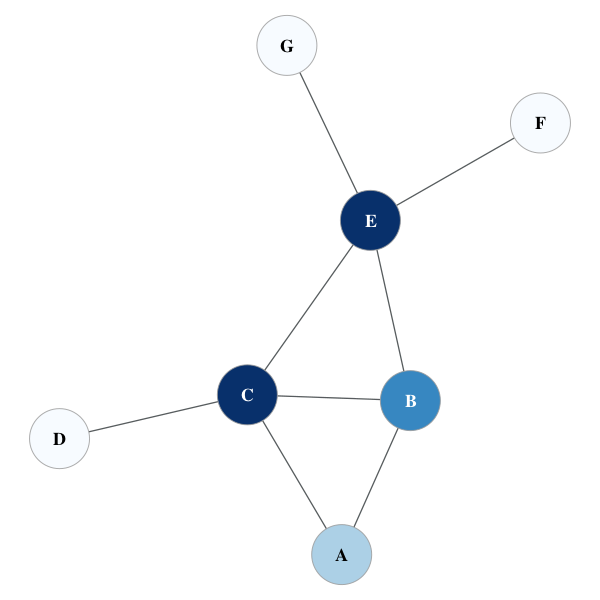

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x1042ddd10, at 0x1197c2b10>

In [28]:
degree = f.degree_property_map('total')

gt.graph_draw(f, pos=gt.sfdp_layout(f),
    vertex_size=60, vertex_text=f.vp.label, vertex_font_weight=1, 
    vertex_font_size=18, vertex_pen_width=1, edge_pen_width=1.3,
    vcmap=cm.Blues, vertex_fill_color=degree,
    output='images/degree_centrality.png',
)

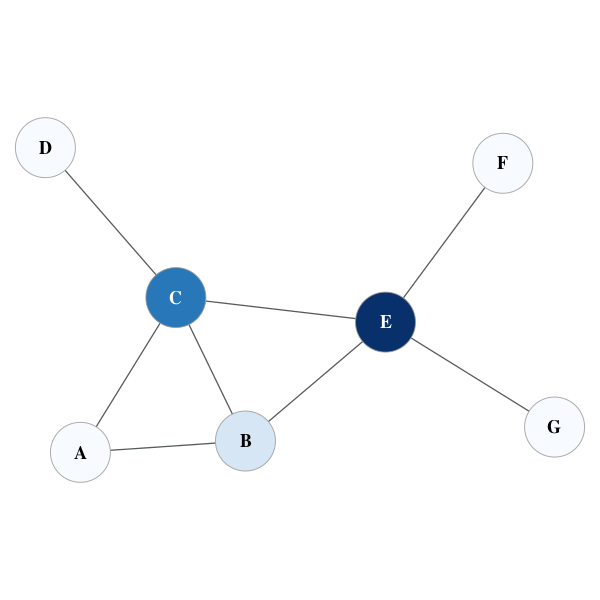

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x1042ddd10, at 0x119822d90>

In [30]:
betweenness, _ = gt.betweenness(f)

gt.graph_draw(f, pos=gt.sfdp_layout(f),
    vertex_size=60, vertex_text=f.vp.label, vertex_font_weight=1, 
    vertex_font_size=18, vertex_pen_width=1, edge_pen_width=1.3,
    vcmap=cm.Blues, vertex_fill_color=betweenness,
    output='images/betweenness_centrality.png',
)

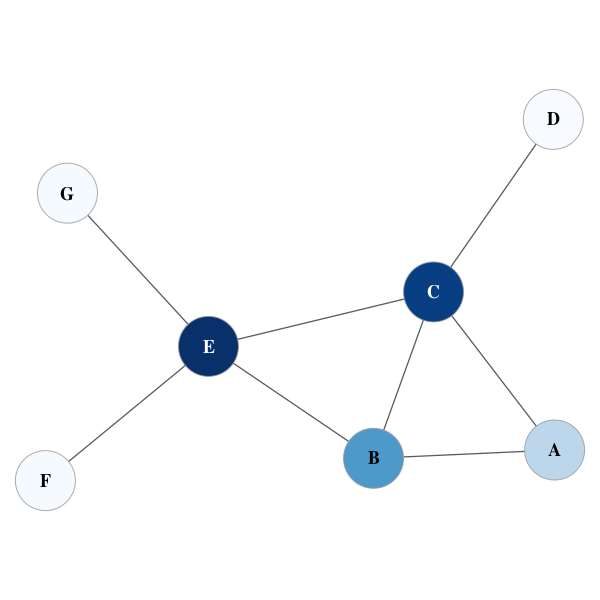

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x1042ddd10, at 0x119822e10>

In [31]:
prank = gt.pagerank(f)

gt.graph_draw(f, pos=gt.sfdp_layout(f),
    vertex_size=60, vertex_text=f.vp.label, vertex_font_weight=1, 
    vertex_font_size=18, vertex_pen_width=1, edge_pen_width=1.3,
    vcmap=cm.Blues, vertex_fill_color=prank,
    output='images/pagrank_centrality.png',
)

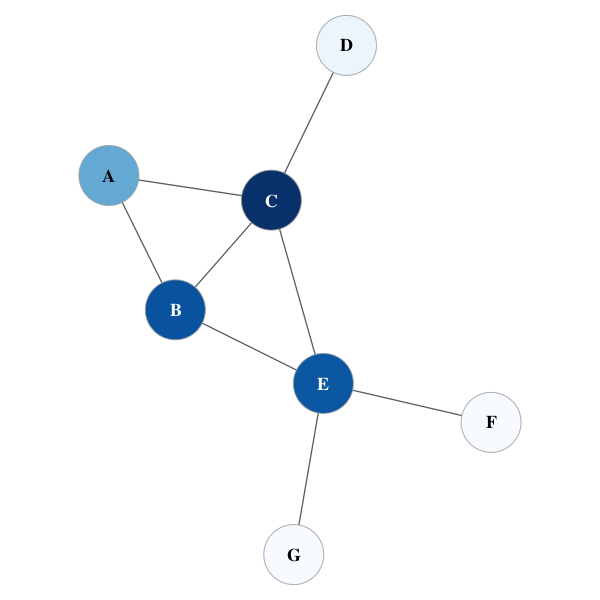

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x1042ddd10, at 0x119822f10>

In [32]:
_, eigencent = gt.eigenvector(f)

gt.graph_draw(f, pos=gt.sfdp_layout(f),
    vertex_size=60, vertex_text=f.vp.label, vertex_font_weight=1, 
    vertex_font_size=18, vertex_pen_width=1, edge_pen_width=1.3,
    vcmap=cm.Blues, vertex_fill_color=eigencent,
    output='images/eigenvector_centrality.png',
)

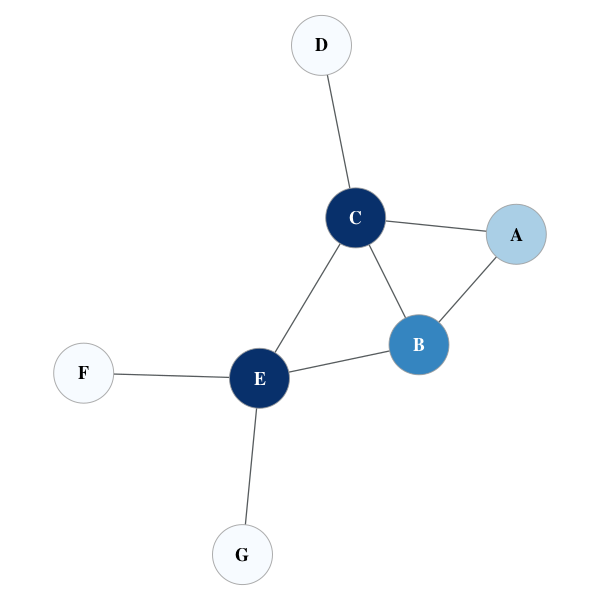

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x1042ddd10, at 0x119822f90>

In [33]:
katz = gt.katz(f)

gt.graph_draw(f, pos=gt.sfdp_layout(f),
    vertex_size=60, vertex_text=f.vp.label, vertex_font_weight=1, 
    vertex_font_size=18, vertex_pen_width=1, edge_pen_width=1.3,
    vcmap=cm.Blues, vertex_fill_color=katz,
    output='images/katz_centrality.png',
)

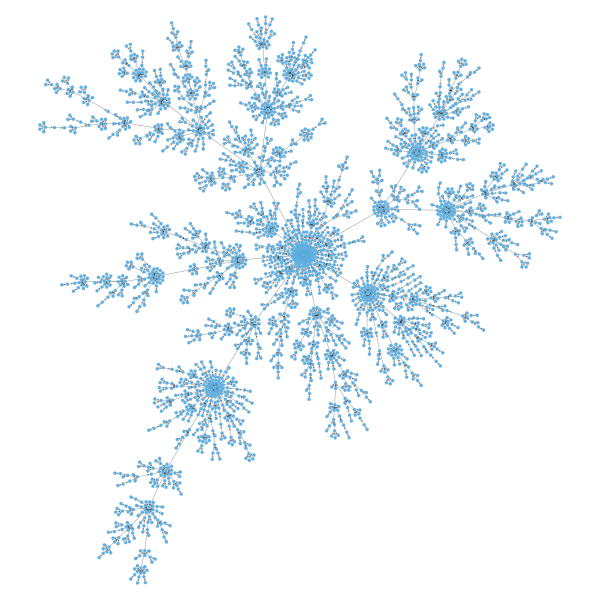

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x1197c2f50, at 0x119c3e610>

In [34]:
H = gt.price_network(3000)
pos = gt.sfdp_layout(H)
gt.graph_draw(H, pos=pos, output="graph-layout-sfdp.png", vertex_fill_color="#4CB5F5")

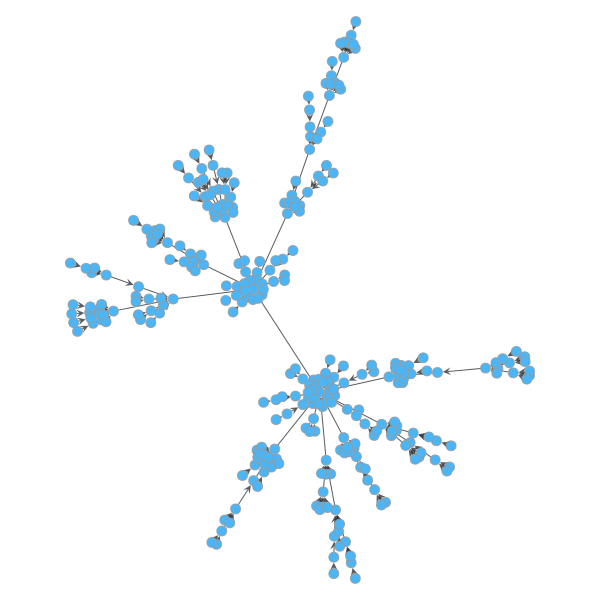

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x11f3ef210, at 0x109c50090>

In [3]:
H = gt.price_network(300)
pos = gt.fruchterman_reingold_layout(H, n_iter=1000)
gt.graph_draw(H, pos=pos, output="images/graph-layout-fr.png", vertex_fill_color="#4CB5F5")

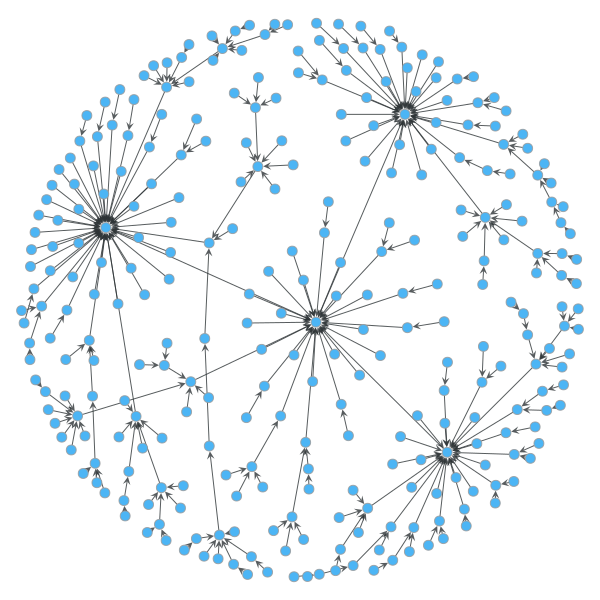

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x1204c4250, at 0x10a938b50>

In [2]:
H = gt.price_network(300)
pos = gt.arf_layout(H, max_iter=0)
gt.graph_draw(H, pos=pos, output="graph-layout-arf.png", vertex_fill_color="#4CB5F5")

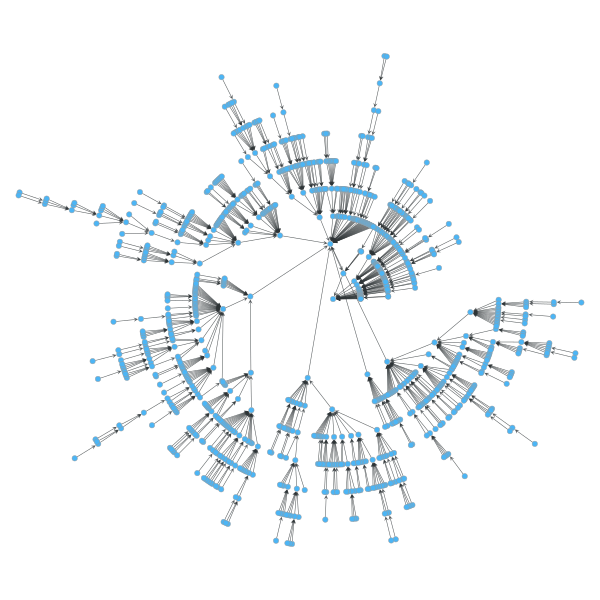

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x1204c4d90, at 0x1204de090>

In [3]:
H = gt.price_network(1000)
pos = gt.radial_tree_layout(H, H.vertex(0))
gt.graph_draw(H, pos=pos, output="graph-layout-radial.png", vertex_fill_color="#4CB5F5")